# Post-Processing Psuedo Surge Runs

- compare bed from 5--15 v.s. 0--15 to figure if we need to re-run. 

In [111]:
import os 
import sys
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as mcolors

# Set global matplotlib style parameters
plt.rcParams.update({'font.size': 14, 
                     'text.usetex': True, 
                     'figure.facecolor': 'w', 
                     'savefig.bbox': 'tight'})

#### Load the `NetCDF` result files

In [2]:
fp      = '/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/Harmonic_Beds_DataShare/R_0.01/*.nc'
files   = sorted(glob.glob(fp))
files.append(files.pop(1))

xarrays = []

for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(np.arange(0,17), name='k'))

# calculate ice-thickness from free surface ans bed
mf_dataset["H"]      = mf_dataset.z_s - mf_dataset.z_b
# correct for incorrect depth average calculation
mf_dataset["v_mean"] = mf_dataset.v_mean * 10/11
mf_dataset["x"] = mf_dataset.x[::-1]/1e3

## Slip Ratios 

Slip ratio characterize the amount of 

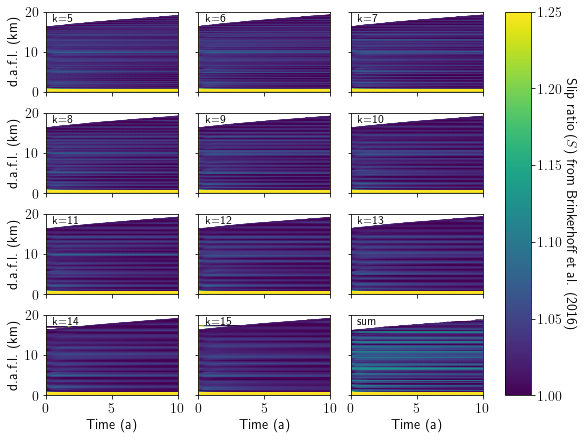

In [114]:
src_masked = mf_dataset.where(mf_dataset.H > 0 )

fig, axes = plt.subplots(4,3, sharex=True, sharey=True, constrained_layout=True,
                        figsize=(8,6))

for i, k in enumerate(range(5,17)):
    ax = axes.ravel()[i]
    ax.set_ylim(None, 20)
    
    img = ax.pcolormesh(src_masked.t, 
                        src_masked.x,
                        (src_masked.v_s / src_masked.v_mean).sel(k=k),
                        shading='gouraud',
                        clim=(1,1.25),
                        vmin=1.0, vmax=1.25)
    if k == 16: 
        ax.text(0.05, 0.875, f"sum", fontsize='small', transform=ax.transAxes)
    else: 
        ax.text(0.05, 0.875, f"k={k}", fontsize='small', transform=ax.transAxes)
    
    if i % 3 == 0 : 
        ax.set_ylabel('d.a.f.l. (km)')
    if i > 8: 
        ax.set_xlabel('Time (a)')    
        
cbar = fig.colorbar(img, ax=axes)

cbar.set_label('Slip ratio ($S$) from Brinkerhoff et al. (2016) ', rotation=270,
               labelpad=15)

fig.savefig('../plots/S_spacetime.png', dpi=300)

In [4]:
for i, k in enumerate(range(5,17)):
    kth_S = (src_masked.v_s / src_masked.v_mean).sel(k=k).mean(('x','t')).values
    
    if k == 16: 
        print("summed, s = {:.2f}".format(kth_S))
    else:
        print("k = {:2}, s = {:.2f}".format(k, kth_S))

k =  5, s = 1.05
k =  6, s = 1.05
k =  7, s = 1.05
k =  8, s = 1.04
k =  9, s = 1.04
k = 10, s = 1.04
k = 11, s = 1.04
k = 12, s = 1.04
k = 13, s = 1.04
k = 14, s = 1.04
k = 15, s = 1.04
summed, s = 1.07


In [44]:
def make_colorbar(array):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, 256))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[-256//array.size:, :] = pink
    newcmp = mcolors.ListedColormap(newcolors)

    cmap = newcmp
    norm = mcolors.Normalize(vmin=np.min(array),
                             vmax=np.max(array))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(array)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (array[1] - array[0]) / 2.0
    bounds   = np.linspace(array[0]   - halfdist,
                           array[-1]  + halfdist,
                           len(array) + 1)

    return cmap, norm, s_map, bounds

In [45]:
cmap, norm, s_map, bounds = make_colorbar(np.arange(5,17))

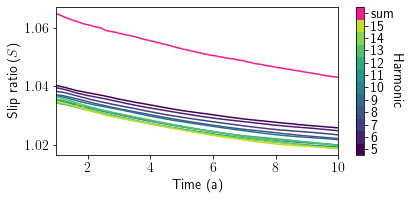

In [150]:
fig, ax = plt.subplots(figsize=(6,3))
# ax.set_aspect(aspect=100)


for i, k in enumerate(np.arange(5,17)):
    
    color = cmap(norm(k))
    v = (src_masked.v_s / src_masked.v_mean).isel(x=slice(0,-20)).mean('x').sel(t=slice(1,100)) 
    ax.plot(v.t,v.isel(k=k), color=color)

ax.set_xlim(v.t.min(), v.t.max())

cbar = fig.colorbar(s_map,
                    spacing='proportional',
                    ticks=np.arange(5,17),
                    ax=ax, 
                    boundaries=bounds)
# colorbar label
cbar.set_label('Harmonic', rotation=270, labelpad=10)
# custom colorbar ticklabels 
cbar.ax.set_yticklabels(["sum" if k==16 else str(k) for k in np.arange(5,17)]);  

ax.set_xlabel('Time (a)');
ax.set_ylabel('Slip ratio ($S$)');

fig.tight_layout()
fig.savefig('../plots/S_over_time.png', dpi=300)

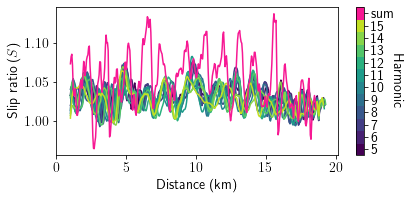

In [148]:
fig, ax = plt.subplots(figsize=(6,3))

for i, k in enumerate(np.arange(5,17)):
    
    color = cmap(norm(k))
    v = (src_masked.v_s / src_masked.v_mean).mean('t').isel(x=slice(0,-20))
    ax.plot(v.x,v.isel(k=k), color=color)

# ax.set_ylim(1.0,1.25)
ax.set_xlim(0, None)

cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=np.arange(5,17),
                ax=ax,
                boundaries=bounds)

# colorbar label
cbar.set_label('Harmonic', rotation=270, labelpad=10)
# custom colorbar ticklabels 
cbar.ax.set_yticklabels(["sum" if k==16 else str(k) for k in np.arange(5,17)]);  

ax.set_xlabel('Distance (km)');
ax.set_ylabel('Slip ratio ($S$)');

fig.tight_layout()
fig.savefig('../plots/S_over_space.png', dpi=300)

In [143]:
v.isel(x=slice(0,-5))

<xarray.DataArray (k: 17, x: 550)>
array([[       nan,        nan,        nan, ..., 1.35884515, 1.36600804,
        1.36499418],
       [       nan,        nan,        nan, ..., 1.353304  , 1.37261559,
        1.35878189],
       [       nan,        nan,        nan, ..., 1.37044527, 1.36730394,
        1.35526394],
       ...,
       [       nan,        nan,        nan, ..., 1.37025853, 1.37977615,
        1.38089916],
       [       nan,        nan,        nan, ..., 1.34990423, 1.35893257,
        1.36032381],
       [       nan,        nan,        nan, ..., 1.35487013, 1.37713749,
        1.36774498]])
Coordinates:
  * x        (x) float64 27.69 27.64 27.59 27.54 ... 0.3999 0.3499 0.2999 0.2499
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

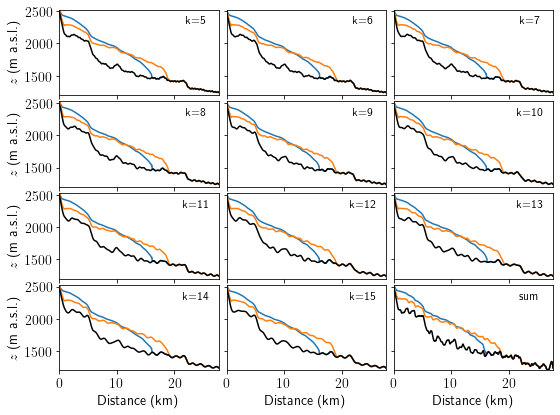

In [109]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(4,3, figsize=(8,6), sharex=True, sharey=True) 

for i, k in enumerate(range(5,17)):
    ax = axes.ravel()[i]
    ax.plot(mf_dataset.x, mf_dataset.isel(k=k, t=0).z_s)
    ax.plot(mf_dataset.x, mf_dataset.isel(k=k, t=-1).z_s)
    ax.plot(mf_dataset.x, mf_dataset.isel(k=k, t=-1).z_b, color='k')
#     ax.plot(mf_dataset.isel(k=i).x, mf_dataset.isel(k=0, t=0).z_b,
#             color='r', alpha=0.75, lw=0.5)

    # ax.fill_between(mf_dataset.x, mf_dataset.isel(k=k, t=-1).z_b,
    #                 color='gray', alpha=0.5)
    
    if k == 16: 
        ax.text(0.85, 0.875, f"sum", fontsize='small', transform=ax.transAxes, ha='center', va='center')
    else: 
        ax.text(0.85, 0.875, f"k={k}", fontsize='small', transform=ax.transAxes, ha='center', va='center')
    
    if i % 3 == 0 : 
        ax.set_ylabel('$z$ (m a.s.l.)')
    if i > 8: 
        ax.set_xlabel('Distance (km)')    

ax.set_xlim(mf_dataset.x.min(), mf_dataset.x.max())
ax.set_ylim(mf_dataset.z_s.min(), mf_dataset.z_s.max())

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.075)
fig.savefig('../plots/kth_freesurface_pre&post_wo_fill.pdf')

In [103]:
# Local plotting functions
# plot_spinup.make_colorbar??

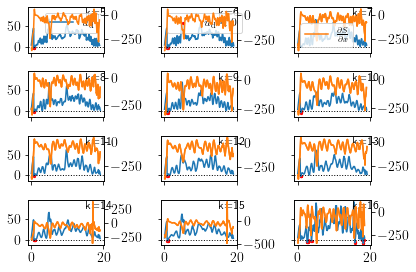

In [115]:
fig, axes = plt.subplots(4,3, sharex=True, sharey=True)


for i, k in enumerate(range(5,17)):
    ax = axes.ravel()[i]
    ax2 = ax.twinx()
    
    mean_v_d = (src_masked.v_s - src_masked.v_b).isel(k=k).mean('t')
    neg_idxs = np.where(mean_v_d < 0)[0]
    
    ax.text(0.75, 0.8, f"k={k}", fontsize='small', transform=ax.transAxes)

    if i == 0: 
        ax.plot(src_masked.x, mean_v_d, label=r'$\bar{u}_{\rm d}$')
        ax.scatter(src_masked.x[neg_idxs], mean_v_d[neg_idxs], c='r', s=5)
        ax.legend(fontsize='small')
    elif i == 1: 
        ax.plot(src_masked.x, mean_v_d)
        ax.scatter(src_masked.x[neg_idxs], mean_v_d[neg_idxs], c='r', s=5, label=r'$\bar{u}_{\rm d} < 0$')
        ax.legend(fontsize='small')   
    elif i == 2: 
        ax.plot(src_masked.x, mean_v_d)
        ax2.plot(src_masked.x, src_masked.isel(k=k).mean('t').z_s.differentiate('x'), c='tab:orange',
                 label=r'$\frac{\partial S}{\partial x}$')
        ax2.legend(fontsize='small')   

    else:     
        ax.plot(src_masked.x, mean_v_d)
        ax.scatter(src_masked.x[neg_idxs], mean_v_d[neg_idxs], c='r', s=5)
        ax2.plot(src_masked.x, src_masked.isel(k=k).mean('t').z_s.differentiate('x'), c='tab:orange')
        
    ax.axhline(0, ls=':', c='k', lw=1.0)
    ax2.plot(src_masked.x, src_masked.isel(k=k).mean('t').z_s.differentiate('x'), c='tab:orange')
    
fig.tight_layout()

# fig.savefig("/Users/andrewnolan/Desktop/time_averaged_u_def_with_dSdx.png", dpi=300, bbox_inches='tight', facecolor='w')

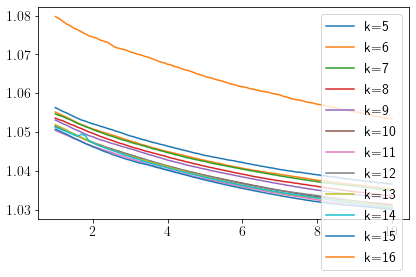

In [117]:
(src_masked.v_s / src_masked.v_mean).mean('t')

# fig, axes = plt.subplots(4,3, sharex=True, sharey=True)

fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    s = (src_masked.v_s / src_masked.v_mean).mean('x').sel(t=slice(1,100))
    ax.plot(s.t, s.isel(k=k), label=f'k={k}')

ax.legend()
fig.tight_layout()

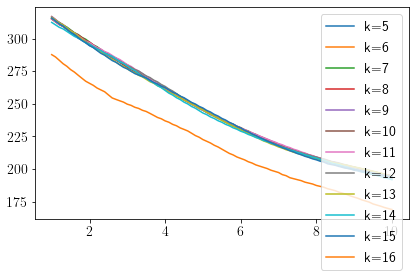

In [118]:
fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    v = src_masked.v_s.mean('x').sel(t=slice(1,100)) 
    ax.plot(v.t,v.isel(k=k), label=f'k={k}')

ax.legend()
fig.tight_layout()

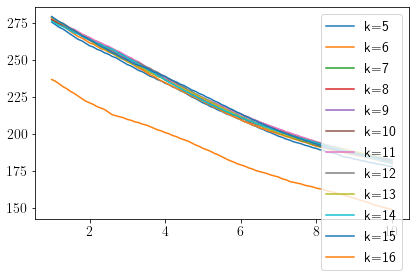

In [119]:
fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    v = src_masked.v_b.mean('x').sel(t=slice(1,100)) 
    ax.plot(v.t,v.isel(k=k), label=f'k={k}')

ax.legend()
fig.tight_layout()

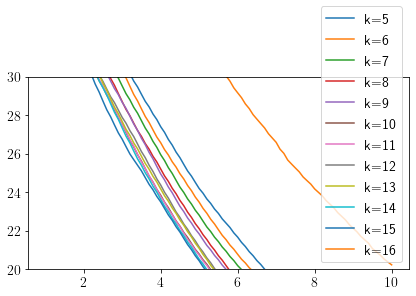

In [120]:
fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    v = (src_masked.v_s - src_masked.v_b).mean('x').sel(t=slice(1,100)) 
    ax.plot(v.t,v.isel(k=k), label=f'k={k}')

ax.legend()
ax.set_ylim(20,30)
fig.tight_layout()

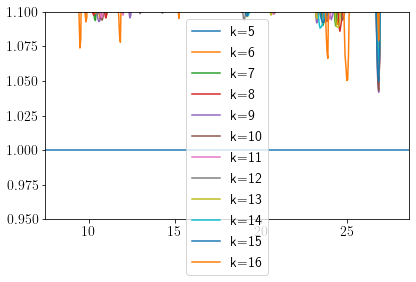

In [121]:
fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    s = (src_masked.v_s / ((src_masked.v_mean*10)/11)).sel(t=slice(1,100)).mean('t')
    ax.plot(s.x[::-1], s.isel(k=k), label=f'k={k}')

ax.axhline(1.0)
ax.set_ylim(0.95, 1.1)
ax.legend()
fig.tight_layout()

/Users/andrewnolan/anaconda3/envs/oggm_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


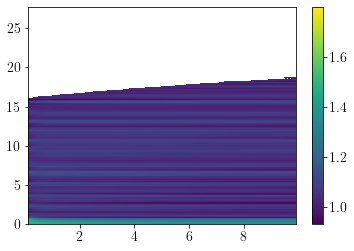

In [123]:
plt.pcolormesh(src_masked.t.isel(t=slice(1,100)), 
               src_masked.x, 
               (src_masked.v_s / src_masked.v_mean).isel(k=16,t=slice(1,100)), 
               clim=(1, 1.5))
plt.colorbar()

In [124]:
(src_masked.v_s / src_masked.v_mean).isel(t=slice(1,100)).mean(('t','x')).std()

<xarray.DataArray ()>
array(0.00623945)

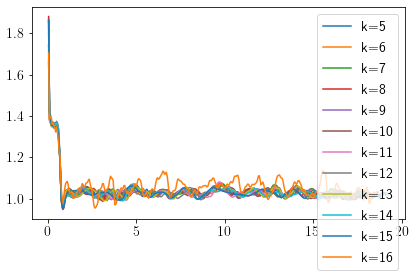

In [125]:
fig, ax = plt.subplots()

for i, k in enumerate(range(5,17)):
    # ax = axes.ravel()[i]

    s = (src_masked.v_s / src_masked.v_mean).sel(t=slice(1,100)).mean('t')
    ax.plot(s.x, s.isel(k=k), label=f'k={k}')

ax.legend()
fig.tight_layout()

/Users/andrewnolan/anaconda3/envs/oggm_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


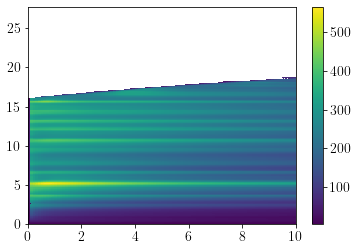

In [128]:
plt.pcolormesh(src_masked.t, 
               src_masked.x,
               src_masked.v_s.isel(k=16), 
              )
plt.colorbar()

In [130]:
import pint 
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams['text.usetex'] = True

ureg = pint.UnitRegistry()

#############################################
# units
#############################################
a   = ureg.year             # [a]
s   = ureg.sec              # [s]
m   = ureg.meter            # [m]
kg  = ureg.kilogram         # [kg]
kPa = ureg('kPa')           # [kPa]
MPa = ureg('MPa')           # [MPa]

#############################################
# parameters (S.I. units)
#############################################
spy   = 365.25*24*60*60 * (s/a)                    # [s a^-1]
ρ     = 910             * (kg*m**-3)               # [Kg m^-3]
g     = 9.81            * (m*s**-2)                # [m s^-2]

#############################################
# parameters (Elmer/Ice)
#############################################
ρ     = ρ * (MPa/MPa.to_base_units()) * spy**-2    # [MPa m^-2 a^2] <--[Kg m^-3]
g     = g * spy**2       

In [131]:
alpha = mf_dataset.isel(k=0,t=0).z_s.differentiate('x').data * m/m
H     = mf_dataset.isel(k=0,t=0).H.data * m

In [132]:
tau_b = ρ * g * H * np.sin(alpha)
beta  = mf_dataset.isel(k=0,t=1).beta.data 

In [133]:
def smooth(x):
    """6-th order low-pass butterworth filter
    """
    import scipy.signal as signal
    sos = signal.butter(6, 1/1e3,'high', fs=1/50, output='sos')

    return signal.sosfiltfilt(sos, x)

smoothed = mf_dataset.z_s.isel(t=-1).groupby("k").map(smooth)

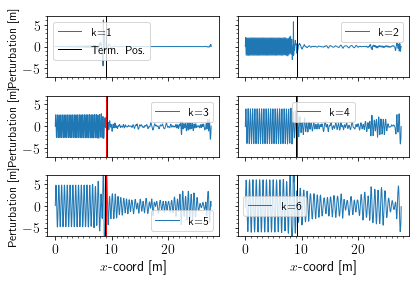

In [134]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

term_loc = (mf_dataset.z_s.isel(t=-1) - mf_dataset.z_b.isel(t=-1)).argmax('x').data

for i, ax in enumerate(axes.ravel()):
    
    pert = (mf_dataset.isel(k=i+1,t=-1).z_s - mf_dataset.isel(k=0,t=-1).z_s) 
    ax.plot(mf_dataset.x[::-1], smooth(pert), lw=1.0, label='k={}'.format(i+1))
    #ax.plot(mf_dataset.x[::-1], pert, lw=1.0, label='k={}'.format(i+1))
    
    if i == 0: 
        ax.axvline(mf_dataset.x[term_loc[i+1]], label='Term. Pos.', ls='-', color='k', lw=1.0)
    else:
        ax.axvline(mf_dataset.x[term_loc[0]], ls='-', color='r', lw=1.0)
        ax.axvline(mf_dataset.x[term_loc[i+1]], ls='-', color='k', lw=1.0)
    ax.legend(fontsize='small')
        
    if i % 2 == 0: 
        ax.set_ylabel('Perturbation [m]', fontsize='small')
    
    if i >= 4: 
        ax.set_xlabel('$x$-coord [m]')
        
axes[-1,-1].set_ylim(-7,7)
axes[-1,-1].set_yticks(np.arange(-7, 8), minor=True);
axes[-1,-1].set_xticks(np.arange(0, 29, 1), minor=True);

#fig.suptitle('No Highpass Filter')
plt.tight_layout()
#plt.savefig('/Users/andrewnolan/Desktop/pert.png', dpi=400, bbox_inches='tight', facecolor='w')

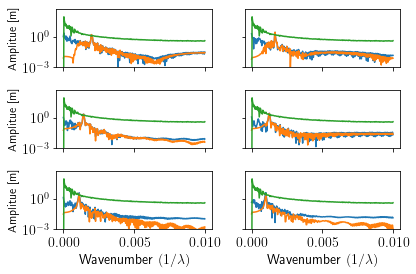

In [139]:
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    
    pert = (mf_dataset.isel(k=i+5,t=-1).z_s - mf_dataset.isel(k=0,t=-1).z_s).data
    
    f_pert, pxx_pert = signal.periodogram(pert,                               
                                          fs=1/50, detrend=False,    scaling='spectrum')
    f_filt, pxx_filt = signal.periodogram(smooth(pert),                       
                                          fs=1/50, detrend=False,    scaling='spectrum')
    f_bed,  pxx_bed  = signal.periodogram(mf_dataset.isel(k=0,t=-1).z_b.data, 
                                          fs=1/50, detrend='linear', scaling='spectrum')

    ax.plot(f_pert, np.sqrt(pxx_pert), label='$z_{\\rm s}$ pert. ($z\'_{\\rm s}$)')
    ax.plot(f_filt, np.sqrt(pxx_filt), label='High pass $z\'_{\\rm s}$')
    ax.plot(f_bed,  np.sqrt(pxx_bed ), label='Detrended Bed')
    
    # ax.legend(title='k={}'.format(i+5), fontsize='xx-small', title_fontsize='x-small')
    
    if i % 2 == 0: 
        ax.set_ylabel('Amplitue [m]', fontsize='small')
    
    if i >= 4: 
        ax.set_xlabel('Wavenumber $(1/\lambda)$')
        
axes[-1,-1].set_yscale('log')
axes[-1,-1].set_ylim(10e-4,None)

plt.tight_layout()
#plt.savefig('/Users/andrewnolan/Desktop/pert_spectrum.png', dpi=400, bbox_inches='tight', facecolor='w')

#plt.rcParams['text.usetex'] = False

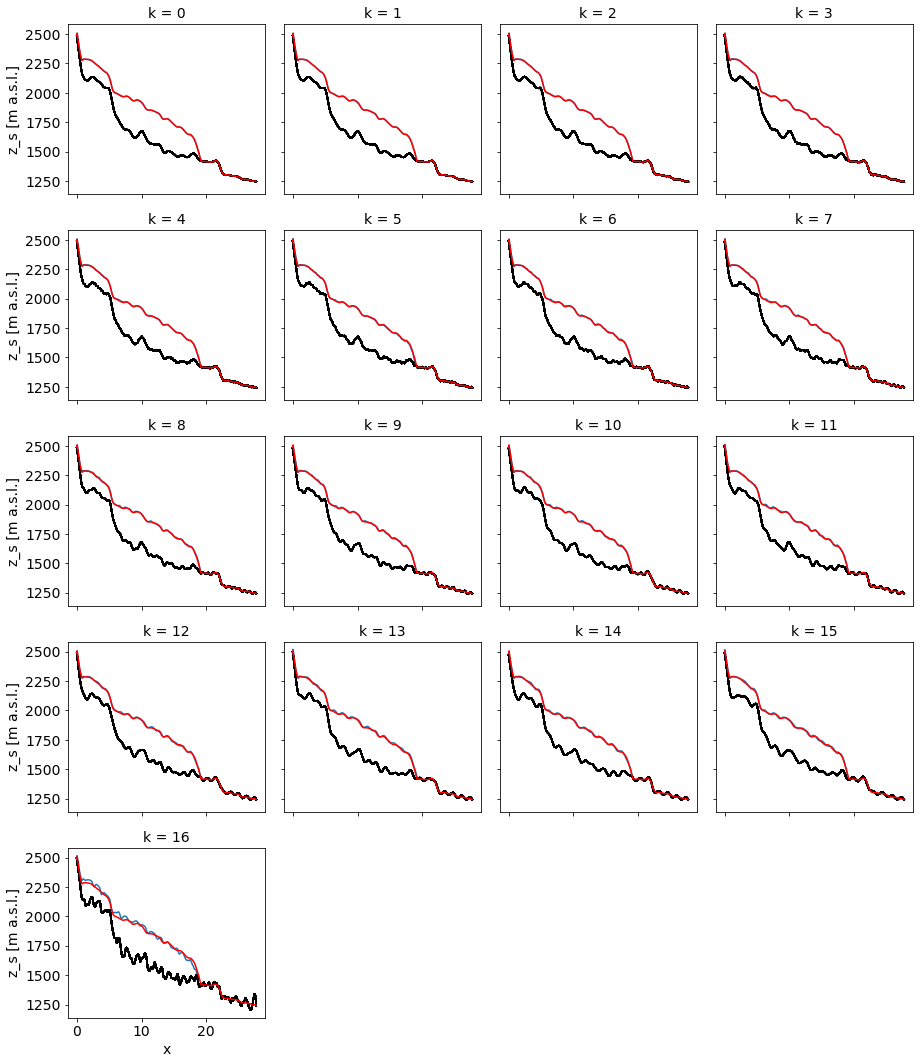

In [138]:
plt.rcParams['text.usetex'] = False

simple_line = mf_dataset.z_s.isel(t=-1).plot(
    x="x", hue="k", col="k", col_wrap=4
)

for i, ax in enumerate(simple_line.axes.ravel()):
    if i < len(mf_dataset.k):
        ax.plot(mf_dataset.x, mf_dataset.isel(k=i).z_b, color='k')
        ax.plot(mf_dataset.x, mf_dataset.isel(k=0, t=-1).z_s, color='r')
    
#plt.savefig('/Users/andrewnolan/Desktop/smoothed_z_s_mean.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
(mf_dataset.isel(k=-1, t=slice(1, -1)).v_b / mf_dataset.isel(k=-1).v_s).mean(('x', 't')) * 100.0 

# A nice animation: 

In [ ]:
from matplotlib import animation, rc

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['savefig.facecolor'] = 'white'
fp = '../Synthetic/perturbed_ratio-0.01/harmonics_01-15_H_100/hdf5/pseudo_k_01-15_10a_dt_0.1_dx_50_mb_1.96_off.nc'

with xr.open_dataset(fp) as Data: 
    
    Data = xr.open_dataset(fp)

In [ ]:
1.5*2.5

# VTU files:

In [ ]:
import os
import meshio
import xarray as xr

In [ ]:
# Find the files matching out run/step name
fp = '../Synthetic/perturbed_ratio-0.01/harmonics_01-15_H_100/VTU/pseudo_k_01-15_10a_dt_0.1_dx_50_mb_1.95_off_t*.vtu'
fn_list = ['../Synthetic/perturbed_ratio-0.01/harmonics_01-15_H_100/VTU/spinup_k_01-15_1000a_dt_1_dx_50_mb_1.96_off_t0002.vtu']
           
fn_list += sorted(glob.glob(fp))

In [ ]:
def vm(vx, vy):
    """Calculate vel. magnitude from x and y component"""
    return np.sqrt(vx**2 + vy**2)

In [ ]:
xgrid_cells = 554
ygrid_cells = 10


xgrid_pts   = xgrid_cells + 1
ygrid_pts   = ygrid_cells + 1

xnodes      = np.array(range(xgrid_pts))      # ynodes 
ynodes      = np.array(range(ygrid_pts))      # xnodes
tsteps      = np.array(range(len(fn_list)))   # number of time steps

timestep = [] #list of data arrays
for path in fn_list:
    t_val = fn_list.index(path)
    mesh = meshio.read(path, file_format= 'vtu') #mesh the file

    z_s  = mesh.point_data['zs'].reshape((ygrid_pts,xgrid_pts))
    z_b  = mesh.point_data['zbed'].reshape((ygrid_pts,xgrid_pts))
    velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts)) #reshape the mesh coordinates
    vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))
    velm = vm(velx,vely)
    
    xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
    ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))

    tempdataset = xr.Dataset(data_vars = {'z_s'   : (('ynode','xnode'), z_s ) ,
                                          'z_b'   : (('ynode','xnode'), z_b ) ,
                                          'vel_x' : (('ynode','xnode'), velx) ,
                                          'vel_y' : (('ynode','xnode'), vely) ,
                                          'vel_m' : (('ynode','xnode'), velm)},
                             coords    = {'yvals' : (('ynode','xnode'), ydim),
                                          'xvals' : (('ynode','xnode'), xdim)})
    timestep.append(tempdataset)

datacomb = xr.concat(timestep, dim='t')

In [ ]:
#datacomb.sel(t=-1).vel_m.plot.contourf(x = 'xvals', y = 'yvals', levels=25)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=500, constrained_layout=True)

vmin = datacomb["vel_m"].min()
vmax = 400

kwargs = {#'levels' : np.linspace(vmin, vmax, 101),
                'vmin'   : vmin, 
                'vmax'   : vmax,
                'cmap'   : 'viridis',
                'shading': 'gouraud'}

im = ax.pcolormesh(datacomb.isel(t=1).xvals[:,::-1]/1e3, 
                   datacomb.isel(t=1).yvals, 
                   datacomb.isel(t=1).vel_m, 
                   **kwargs)  


# Set up the colorbar
cbar = fig.colorbar(im, ticks=np.linspace(0, vmax, 6))

cbar.set_label('Velocity [m a$^-1$]', rotation=270, labelpad=20)

ax.set_ylim(1400, None)
ax.set_xlim(datacomb.xvals.min()/1e3, 22.5)
ax.set_ylabel('Elevation (m a.s.l.)')
ax.set_xlabel('Distance from divide (km)')
ax.set_title(r'$z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=5}^{15} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')



ax.fill_between(datacomb.sel(t=0).xvals[0,::-1]/1e3, 
                np.zeros(xgrid_cells+1), 
                datacomb.sel(t=0).z_b[0,:], color='saddlebrown', alpha=0.5)

# Add time annotation
label = ax.text(0.9, 0.9, r"$t=0$",
                transform=ax.transAxes,
                ha='center', va='center')

def animate(i):
    # Wipe the axis
    ax.collections = []
    # Plot the contour
    ax.pcolormesh(datacomb.sel(t=i).xvals[:,::-1]/1e3, 
                  datacomb.sel(t=i).yvals, 
                  datacomb.sel(t=i).vel_m, 
                  **kwargs) 
    
    # Update time annotation
    label.set_text("$t={{{:6.1f}}}$".format(datacomb.t[i].values/10.))
    
    ax.fill_between(datacomb.sel(t=i).xvals[0,::-1]/1e3, 
                    np.zeros(xgrid_cells+1), 
                    datacomb.sel(t=i).z_b[0,:], color='saddlebrown', alpha=0.5)
    

anim = animation.FuncAnimation(
    fig, animate, interval=100, frames=np.arange(0,101))

ax.plot(Data.x[::-1]/1e3, datacomb.isel(t=0 ).z_s[-1,:], 'k:', alpha=0.5, lw=1.0, label='$z_s(t=0.0)$')
ax.plot(Data.x[::-1]/1e3, datacomb.isel(t=-1).z_s[-1,:], 'k' , alpha=0.5, lw=1.0, label='$z_s(t=10.0)$')

ax.legend(loc='lower left')

plt.close()
#anim

In [ ]:
anim.save('/Users/andrewnolan/Desktop/velocity_anim.mp4', fps=10, dpi=500,
          codec="libx264", extra_args=['-pix_fmt', 'yuv420p'], bitrate=1e6)#,
          #progress_callback = lambda i, n: print(f'Saving frame {i} of {n}') )

In [ ]:
datacomb.to_netcdf("/Users/andrewnolan/Desktop/test_xarray.nc")